# Evolución del COVID-19

19 de mayo de 2020

El trabajo consiste en analizar la evolución de contagios de COVID-19 en el mundo.

1. [Tema del estudio y herramienta de ejecución / despliegue](#ATema-del-estudio-y-herramienta-de-ejecución-/-despliegue)
2. [Antecedentes](#Antecedentes)
3. [Análisis internacional](#Análisis-internacional)
4. [Análisis estatal](#Análisis-estatal)
5. [Modelos SIRS](#Modelos-SIRS)
6. [Conclusiones](#Conclusiones)

In [1]:
# Se improtan las paqueterías que se utilizarán
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import plotly.express as px
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from datetime import datetime, timedelta
import math
import altair as alt

pd.options.display.float_format = '{:,.2f}'.format

# Tema del estudio y herramienta de ejecución / despliegue

Se analiza la evolución del número de contagios de COVID-19 en el plano internacional y luego en el estatal. Asimismo, utilizando un modelo SIRS se realiza una predicción de los contagios a 1 y 6 meses al día de hoy.

Se utiliza código Python, en donde se hace uso principalmente de las paqueterías de Pandas, Numpy y Matplotlib.

# Antecedentes

Para los datos internacionales se utiliza la base de Johns Hopkins University y para los estatales la base de serendipia digital, la cual utiliza datos de la Secretaría de Salud.


# Análisis internacional

In [2]:
# Se utiliza la base de Johns Hopkins University, la cuál descargamos directo a través de la siguientse ligas

# Liga para evolución de confirmados
link_conf = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

# Liga para evolución de muertos
link_muer = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'


# Cargamos primero la base de datos de casos confirmados
conf_df = pd.read_csv(link_muer)

# Se agrupa por país y región para tener datos por país
conf_df = conf_df.groupby(['Country/Region'], as_index=False).sum()

# Se eliminan columnas que no son de interés
del conf_df['Lat'], conf_df['Long']

# Para pasar las columnas de fechas a filas y las filas de países a columnas, pivoteamos la base
conf_df = pd.pivot_table(conf_df, columns='Country/Region')

# Reseteamos el index para poder iterar despúes
conf_df.reset_index(inplace=True)

# Cambiamos el nombre de la columna del index a fechas
conf_df.rename(columns={"index": "Date"}, inplace=True)

# Convertimos la base en datetime
conf_df["Date"] = pd.to_datetime(conf_df["Date"])

conf_df["Date"] = conf_df["Date"] - pd.DateOffset(days=1)

conf_df.sort_values(by='Date', inplace=True)

totals = conf_df.sum(axis=0).sort_values(ascending=False).reset_index()

paises_lat = ['Argentina', 'Belize', 'Bolivia', 'Brazil', 'Dominican Republic',
               'Colombia', 'Chile', 'Costa Rica', 'Ecuador', 'Cuba', 'Panama',
               'El Salvador', 'Guatemala', 'Honduras', 'Paraguay', 'Peru']

conf_df_lat = conf_df[paises_lat]

totals_lat = conf_df_lat.sum(axis=0).sort_values(ascending=False).reset_index()

mex_arr = np.array(conf_df['Mexico'], dtype=float)

mex_arr = mex_arr[mex_arr != 0]

#Se agregar un 1 al inicio que sería el cambio de cero a un infectado del primer día
mex_arr_diff = np.diff(mex_arr)

mex_arr_diff = np.append(1, mex_arr_diff)

log_mex_arr = np.log(mex_arr)


# Ahora trabajamos con los tiempos
month_name = conf_df['Date'].dt.month_name()

month_name = np.array([i[0:3] for i in month_name])

month = np.array(conf_df['Date'].dt.month)

day = np.array(conf_df['Date'].dt.day)

year = np.array(conf_df['Date'].dt.year)

date = ['-'.join((str(day[i]), str(month_name[i])) )for i in range(len(month_name))]

date_mex = date[-len(mex_arr):]

# Estimados las fechas para 1 mes y 6 meses

#Pero primero calculamos el último día más uno, para generar una serie de los días
last_day_plus1 = conf_df["Date"][-1:] + timedelta(days=1)

def date_to_string(date):
    
    l_day = str(np.array(date[-1:].dt.day)[0])
    l_month = str(np.array(date[-1:].dt.month)[0])
    l_year = str(np.array(date[-1:].dt.year)[0])

    return str(l_month) + '/' + str(l_day) + '/' + str(l_year)


dates_1_mes = pd.to_datetime(pd.date_range(start=date_to_string(last_day_plus1), end=date_to_string(last_day_plus1 + timedelta(days=30)))) 

dates_6_mes = pd.date_range(start=date_to_string(last_day_plus1), end=date_to_string(last_day_plus1 + timedelta(days=180)))

# Creamos una fucnión para los labels de las fechas en las gráficas
def serie_dates(dates_array):
    
    month_name = dates_array.month_name()

    month_name = np.array([i[0:3] for i in month_name])
    
    day = np.array(dates_array.day)
    
    date = ['-'.join((str(day[i]), str(month_name[i])) )for i in range(len(month_name))]
    
    return date

dates_1_mes = serie_dates(dates_1_mes)

dates_6_mes = serie_dates(dates_6_mes)

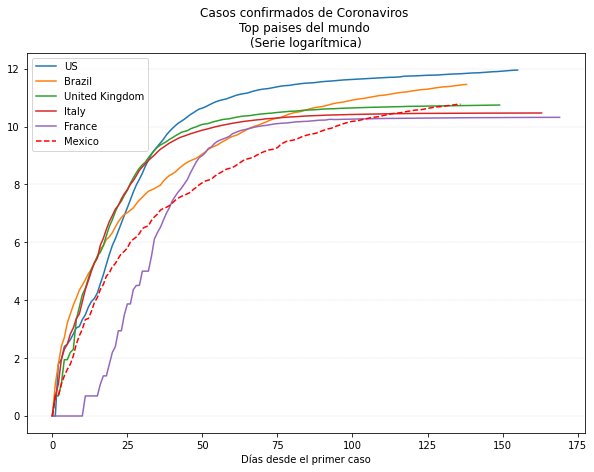

In [3]:
rank_5 = list(totals['Country/Region'][0:5])

plt.figure(figsize=(10, 7))

for i in rank_5:
    
    array = np.array(conf_df[i])
    
    array = array[array != 0]
    
    log_array = np.log(array)
    
    plt.plot(log_array)

rank_5.append('Mexico')

plt.plot(log_mex_arr, linestyle='--', color='red')
plt.title('Casos confirmados de Coronaviros \nTop paises del mundo \n(Serie logarítmica)')
plt.grid(axis='y', linestyle='--', linewidth=0.2)
plt.legend(rank_5)
plt.xlabel('Días desde el primer caso')
plt.show()

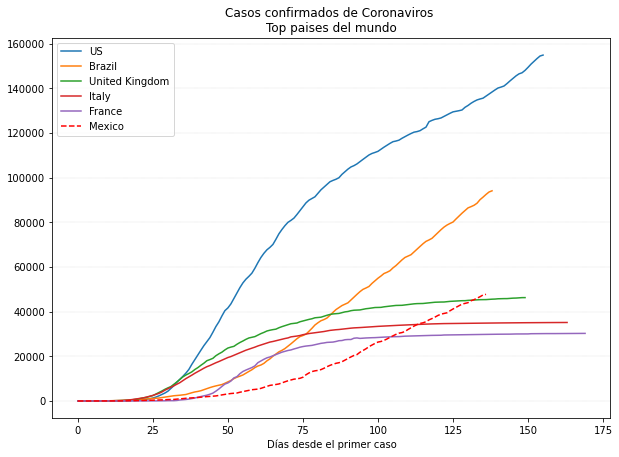

In [4]:
# Hacemos la mundial, ahora series normales

rank_5 = list(totals['Country/Region'][0:5])

plt.figure(figsize=(10, 7))

for i in rank_5:
    
    array = np.array(conf_df[i])
    
    array = array[array != 0]
    
    plt.plot(array)

rank_5.append('Mexico')

plt.plot(mex_arr, linestyle='--', color='red')
plt.title('Casos confirmados de Coronaviros \nTop paises del mundo')
plt.grid(axis='y', linestyle='--', linewidth=0.2)
plt.legend(rank_5)
plt.xlabel('Días desde el primer caso')
plt.show()


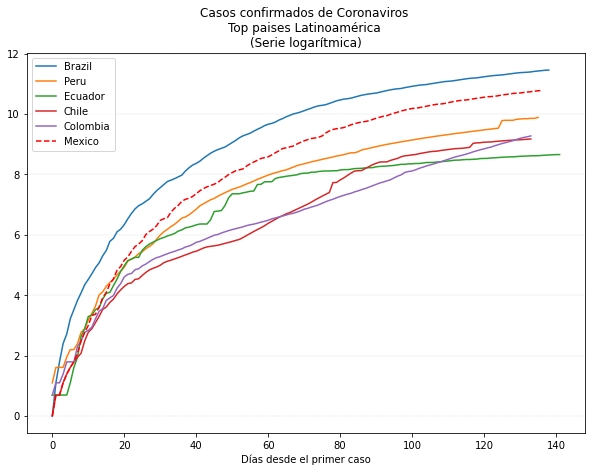

In [5]:
#Ahora para latinoameirca

# Primero la logarítmica
rank_5_lat = list(totals_lat['Country/Region'][0:5])

plt.figure(figsize=(10, 7))

for i in rank_5_lat:
    
    array = np.array(conf_df_lat[i])
    
    array = array[array != 0]
    
    log_array = np.log(array)
    
    plt.plot(log_array)

rank_5_lat.append('Mexico')

plt.plot(log_mex_arr, linestyle='--', color='red')
plt.title('Casos confirmados de Coronaviros \nTop paises Latinoamérica \n(Serie logarítmica)')
plt.grid(axis='y', linestyle='--', linewidth=0.2)
plt.legend(rank_5_lat)
plt.xlabel('Días desde el primer caso')
plt.show()

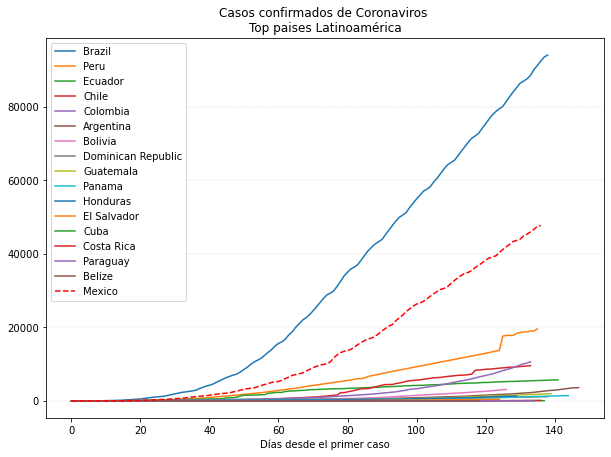

In [6]:
# Serie normal

rank_5_lat = list(totals_lat['Country/Region'])

plt.figure(figsize=(10, 7))

for i in rank_5_lat:
    
    array = np.array(conf_df_lat[i])
    
    array = array[array != 0]
    
    plt.plot(array)

rank_5_lat.append('Mexico')

plt.plot(mex_arr, linestyle='--', color='red')
plt.title('Casos confirmados de Coronaviros \nTop paises Latinoamérica')
plt.grid(axis='y', linestyle='--', linewidth=0.2)
plt.legend(rank_5_lat)
plt.xlabel('Días desde el primer caso')
plt.show()




# Análisis estatal

In [7]:
link = 'https://serendipia.digital/wp-content/uploads/2020/05/covid-19-mexico-16052020.csv'

conf_edos = pd.read_csv(link)

In [8]:
conf_edos = conf_edos.groupby(['Nom_Ent', 'FECHA_SINTOMAS'], as_index=False)[['RESULTADO']].count()

conf_edos.columns = ['Estado', 'Fecha de Inicio de síntomas', 'Contagiados']

In [9]:
conf_edos.sort_values(by=['Estado', 'Fecha de Inicio de síntomas'], inplace=True)

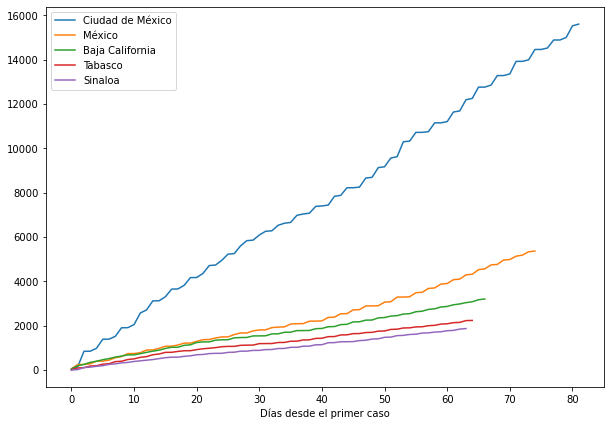

In [10]:
rank_edos = conf_edos.groupby('Estado', as_index=False)[['Contagiados']].sum()

rank_edos = rank_edos.sort_values(by = 'Contagiados', ascending=False)

rank_edos_top5 = list(rank_edos[:5]['Estado'])

plt.figure(figsize=(10, 7))

for edo in rank_edos_top5:
    
    base = conf_edos[conf_edos['Estado'] == edo]['Contagiados']

    array = np.array(base)
    
    array = array[array != 0]
    
    array = np.cumsum(array,axis=0) 
    
    plt.plot(array)
    
plt.legend(rank_edos_top5)
plt.xlabel('Días desde el primer caso')
plt.show()

# Modelos SIRS

La estimación se realiza ajustando la curva de crecimiento de los casos confirmados a a través de un models SIRS. Este modelo se realiza con base en la selección de dos parámetros que minimicen los errores al cuadrado. Los parámetros son beta y gamma. La beta se refiere a la tasa de contagio y la gamma a la tasa en que los individuos recuperados regresan a ser de nuevo población susceptible.

In [11]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
N = 128603589
# Initial number of infected and recovered individuals, I0 and R0.
I0 = 1
R0 = 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
# A grid of time points (in days)

t = [i for i in range(len(date_mex))]

x = [i for i in range(1,len(date_mex) + 1)]

t_fut = [i for i in range(len(dates_6_mes) + len(date_mex))]


# The SIR model differential equations.
def deriv(y, x, beta, gamma):
    S, I, R = y
    dSdt = - (beta * S * I) / N
    dIdt = (beta * S * I) / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector

def pred(x, beta, gamma):
    
    y0 = S0, I0, R0
    
    return odeint(deriv, y0, x, args=(beta, gamma))[:,1]

popt, pcov = curve_fit(pred, x, mex_arr_diff)

fit = pred(t, *popt)

forcast = pred(t_fut, *popt)

std_err = math.sqrt(sum((mex_arr_diff - forcast[:len(mex_arr_diff)])**2))

# Adelantamos las estimaciones en 1 día
forcast = np.roll(forcast, 2)

forcast[0] = 1


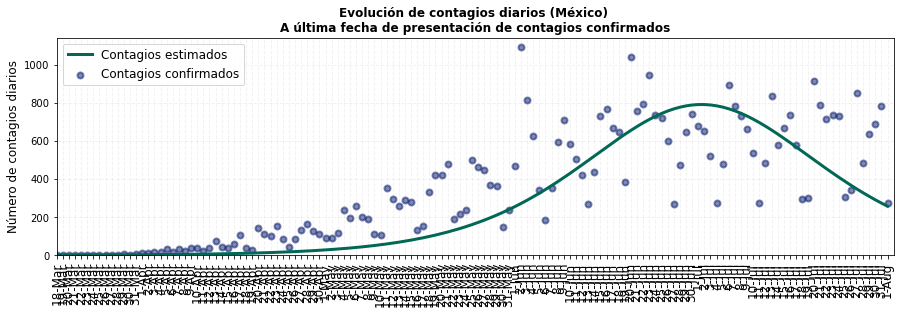

In [12]:
# Estimamos gráfica de contagios diarios
plt.figure(figsize=(15,4), facecolor='w')
plt.scatter(y= mex_arr_diff, x = date_mex, alpha=0.5, lw=2, label='Contagios confirmados', color='#001568')
plt.plot(fit, color='#006854', alpha=1, lw=3, label='Contagios estimados')
plt.ylim(0, max(mex_arr_diff) + 50), plt.xlim(0,len(mex_arr_diff))
plt.ylabel('Número de contagios diarios', fontsize = 'large')
plt.title('Evolución de contagios diarios (México) \nA última fecha de presentación de contagios confirmados',
         fontweight="bold", fontsize = 'large')
plt.xticks(date_mex, rotation='vertical', fontsize = 'large')
plt.grid(b=True, which='major', c='grey', lw=1, ls='--', alpha=.1)
plt.margins(1)
plt.legend(fontsize = 'large')
plt.show()

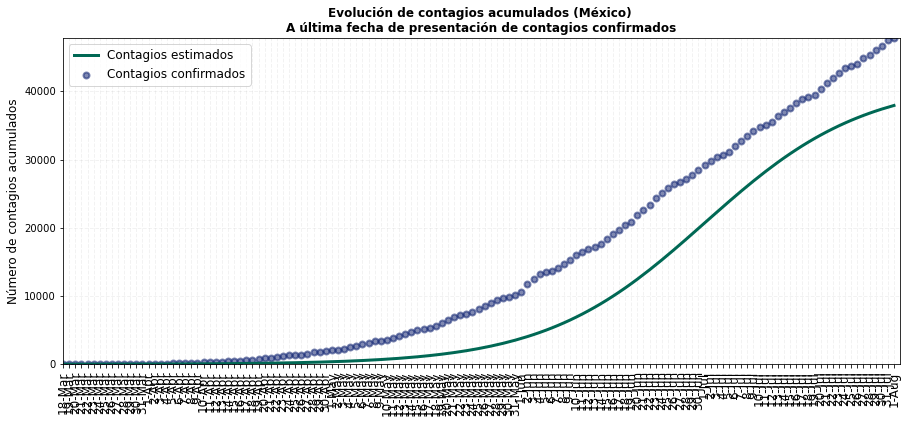

In [13]:
# Despúes estimamos los acumulados
plt.figure(figsize=(15,6), facecolor='w')
plt.scatter(y= mex_arr, x = date_mex, alpha=0.5, lw=2, label='Contagios confirmados', color='#001568')
plt.plot(np.cumsum(fit), color='#006854', alpha=1, lw=3, label='Contagios estimados')
plt.ylim(0, max(mex_arr) + 50), plt.xlim(0,len(mex_arr))
plt.ylabel('Número de contagios acumulados', fontsize = 'large')
plt.title('Evolución de contagios acumulados (México) \nA última fecha de presentación de contagios confirmados',
         fontweight="bold")
plt.xticks(date_mex, rotation='vertical', fontsize = 'large')
plt.grid(b=True, which='major', c='grey', lw=1, ls='--', alpha=.1)
plt.margins(1)
plt.legend(fontsize = 'large')
plt.show()

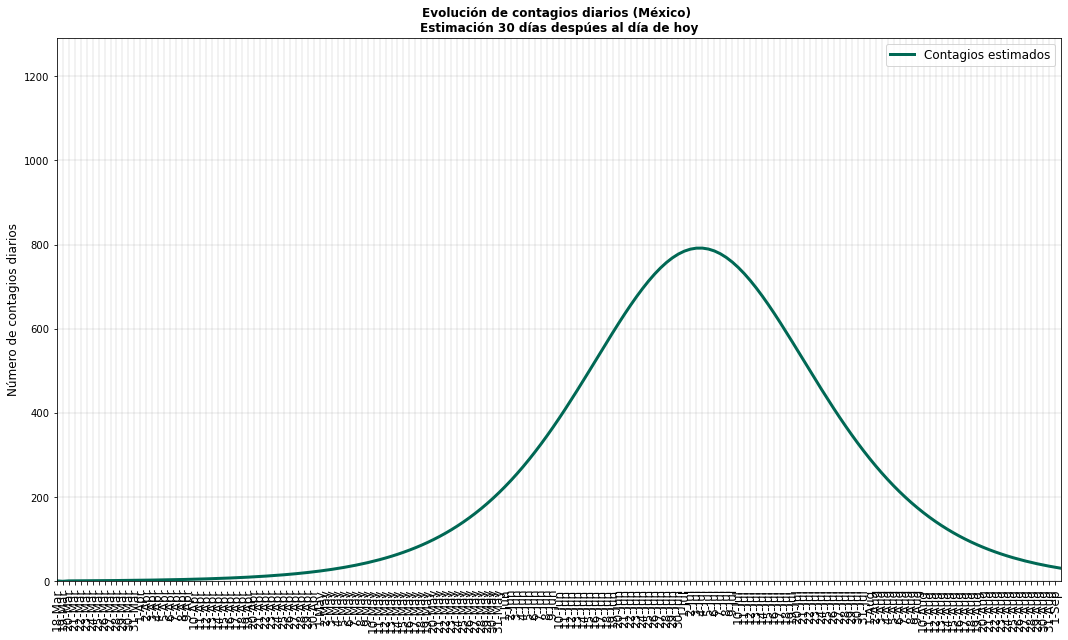

In [14]:
ci = 1.96 * std_err
# concatenamos las fechas que utilizamremos para la estimación del mes
fechas_1mes = date_mex + dates_1_mes

plt.figure(figsize=(18, 10))

plt.plot(forcast, color='#006854', alpha=1, lw=3, label='Contagios estimados')

plt.ylabel('Número de contagios diarios', fontsize = 'large')
plt.title('Evolución de contagios diarios (México) \nEstimación 30 días despúes al día de hoy',
         fontweight="bold")
plt.ylim(0, max(forcast[:len(fechas_1mes)] + 500)), plt.xlim(0,len(fechas_1mes))
plt.grid(b=True, which='major', c='grey', lw=2, ls='-', alpha=.1)
plt.xticks(ticks= t_fut[:len(fechas_1mes)], labels=fechas_1mes, rotation='vertical', fontsize = 'large')
plt.legend(fontsize = 'large')

plt.show()

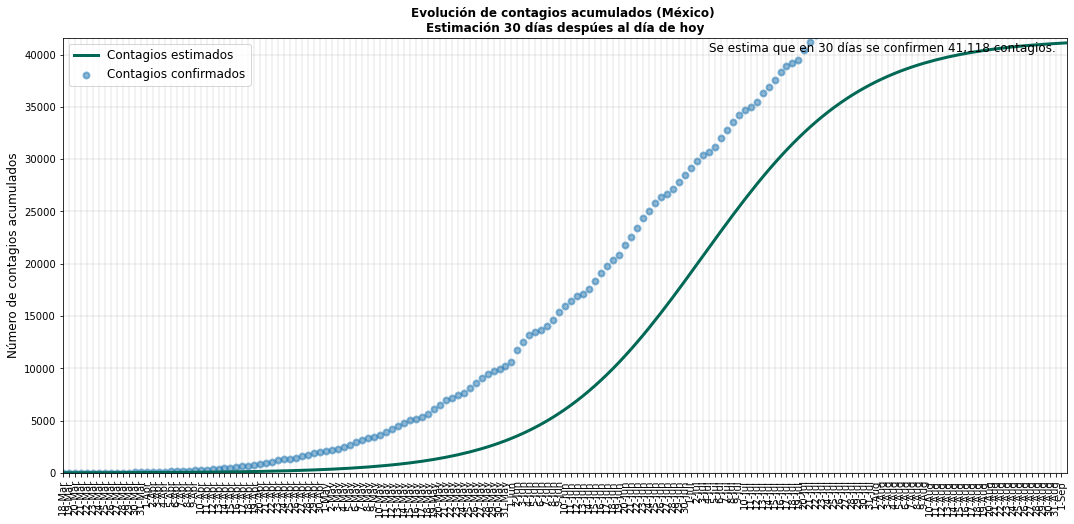

In [15]:
# Estimalos los intervalos de confianza para las series acumuladas
forcast_acum = np.cumsum(forcast)
up_b = np.cumsum(forcast+ci)
lo_b = forcast-ci
# Remplazamos valores menores a cero para que nuestra estimación del d
lo_b[lo_b < 0] = 0
lo_b = np.cumsum(lo_b)

# Graficamos la estimación acumulada a 1 mes
plt.figure(figsize=(18,8), facecolor='w')
plt.plot(forcast_acum, color='#006854', alpha=1, lw=3, label='Contagios estimados')
plt.scatter(y= mex_arr, x = date_mex, alpha=0.5, lw=2, label='Contagios confirmados')
plt.ylabel('Número de contagios acumulados', fontsize = 'large')
plt.title('Evolución de contagios acumulados (México) \nEstimación 30 días despúes al día de hoy',
         fontweight="bold")
plt.ylim(0, max(forcast_acum[:len(fechas_1mes)] + 500)), plt.xlim(0,len(fechas_1mes))
plt.grid(b=True, which='major', c='grey', lw=2, ls='-', alpha=.1)
plt.xticks(ticks= t_fut[:len(fechas_1mes)], labels=fechas_1mes, rotation='vertical', fontsize = 'medium')
texto = 'Se estima que en 30 días se confirmen {:,.0f} contagios.'.format(
            forcast_acum[len(fechas_1mes)], up_b[len(fechas_1mes)], lo_b[len(fechas_1mes)])
plt.text(x=fechas_1mes[-60], y= forcast_acum[len(fechas_1mes)-15], 
         s=texto, fontsize = 'large')
plt.legend(fontsize = 'large')
plt.show()

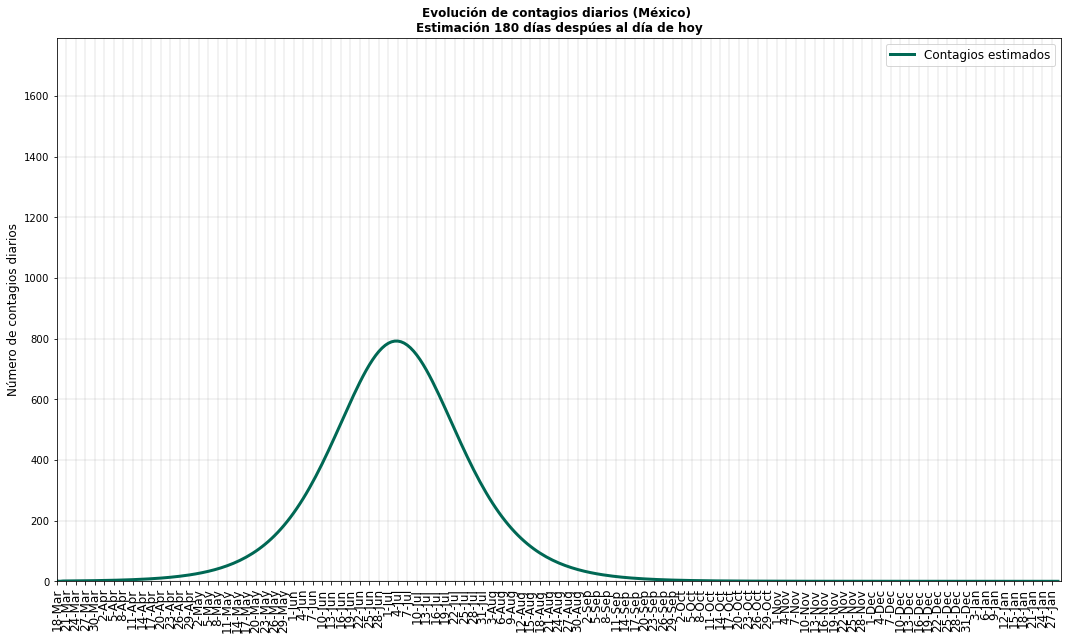

In [16]:
# concatenamos las fechas que utilizamremos para la estimación de los 6 meses
fechas_6meses = date_mex + dates_6_mes

plt.figure(figsize=(18, 10))
plt.plot(forcast, color='#006854', alpha=1, lw=3, label='Contagios estimados')
plt.ylabel('Número de contagios diarios', fontsize = 'large')
plt.title('Evolución de contagios diarios (México) \nEstimación 180 días despúes al día de hoy',
         fontweight="bold")
plt.ylim(0, max(forcast[:len(fechas_6meses)] + 1000)), plt.xlim(0,len(fechas_6meses))
plt.grid(b=True, which='major', c='grey', lw=2, ls='-', alpha=.1)
plt.xticks(ticks= t_fut[:len(fechas_6meses)], labels=fechas_6meses[0::3], rotation='vertical', fontsize = 'large')
plt.locator_params(nbins=len(fechas_6meses[0::3]), axis='x')
plt.legend(fontsize = 'large')
plt.show()

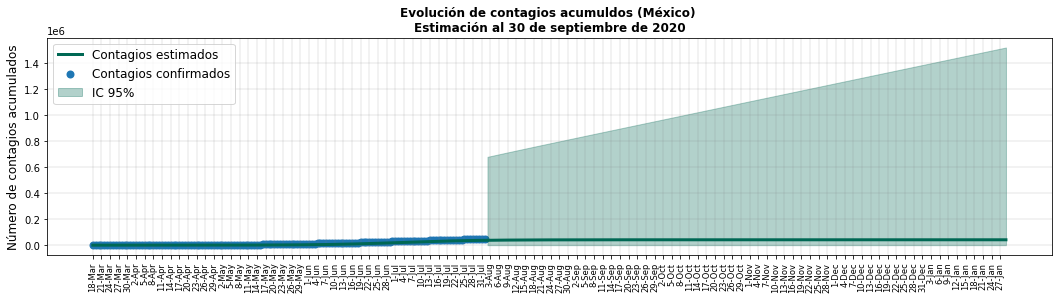

In [17]:

# Graficamos la estimación acumulada a 6 mes
plt.figure(figsize=(18,4), facecolor='w')
plt.plot(forcast_acum, color='#006854', alpha=1, lw=3, label='Contagios estimados')
plt.scatter(y= mex_arr, x = date_mex, alpha=1, lw=2, label='Contagios confirmados')
plt.fill_between(t_fut[len(mex_arr):], lo_b[len(mex_arr):], up_b[len(mex_arr):], color='#006854', alpha=.3, label='IC 95%')
plt.ylabel('Número de contagios acumulados', fontsize = 'large')
plt.title('Evolución de contagios acumuldos (México) \nEstimación al 30 de septiembre de 2020',
         fontweight="bold")
plt.grid(b=True, which='major', c='grey', lw=2, ls='-', alpha=.1)
plt.xticks(ticks= t_fut[:len(fechas_6meses)], labels=fechas_6meses[0::3], rotation='vertical', fontsize = 'small')
plt.locator_params(nbins=len(fechas_6meses[0::3]), axis='x')
plt.legend(fontsize = 'large', loc ='upper left')
plt.show()

# Conclusiones

Se estima que en 30 días se confirmen más de 70 mil contagios y el pico de la pandemia ya haya pasado con más de 2,000 contagios en un mismo día.

#### Conclusiones de las ventajas / desventajas de la elaboración del trabajo con el medio seleccionado

Se trabajó con las ventajas de Python, haciendo uso de la paquetería Pandas, Numpy y Matplotlib que, una vez que se conoce la sintaxis, es sencillo y rápido para el análisis de datos.

